# MONAI : Tutorial : 3d_registration
## Paired Lung CT 3d registration with MONAI

タスク: 
- 一人の患者の異なる時点で取得されたCT画像を登録

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/3d_registration

## 0. 準備

In [1]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.nn import MSELoss

from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import LocalNet
from monai.transforms import (
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityRanged,
)
from monai.utils import set_determinism, first

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/pytorch/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.10.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# 乱数シードの設定
set_determinism(seed=2023)

## 1. データセットの準備
### 1.1 データのダウンロード

In [3]:
root_dir = os.path.realpath('./data')
os.makedirs(root_dir, exist_ok=True)

print(root_dir)

/home/akira/Medical/MONAI/3d_registration/data


In [4]:
# データのダウンロード
resource = "https://zenodo.org/record/3835682/files/training.zip"

compressed_file = os.path.join(root_dir, 'paired_ct_lung.zip')
data_dir = os.path.join(root_dir, 'paired_ct_lung')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)
    os.rename(os.path.join(root_dir, 'training'), data_dir)


### 1.2 データの確認

In [5]:
# データセットパスの設定
data_dicts = [
    {
        'fixed_image': os.path.join(data_dir, 'scans/case_%03d_exp.nii.gz' % idx),
        'moving_image': os.path.join(data_dir, 'scans/case_%03d_insp.nii.gz' % idx),
        'fixed_label': os.path.join(data_dir, 'lungMasks/case_%03d_exp.nii.gz' % idx),
        'moving_label': os.path.join(data_dir, 'lungMasks/case_%03d_insp.nii.gz' % idx),
    }
    for idx in range(1, 21)
]

train_files, val_files = data_dicts[:18], data_dicts[18:]

In [6]:
# トランスフォームの設定
train_transforms = Compose(
    [
        LoadImaged(
            keys=['fixed_image', 'moving_image', 'fixed_label', 'moving_label'],
            ensure_channel_first=True
        ),
        ScaleIntensityRanged(
            keys=['fixed_image', 'moving_image'],
            a_min=-285, a_max=3770, b_min=0., b_max=1., clip=True,
        ),
        RandAffined(
            keys=['fixed_image', 'moving_image', 'fixed_label', 'moving_label'],
            mode=('bilinear', 'bilinear', 'nearest', 'nearest'),
            prob=1.0, spatial_size=(192, 192, 208),
            rotate_range=(0, 0, np.pi / 15), scale_range=(0.1, 0.1, 0.1)
        ),
        Resized(
            keys=['fixed_image', 'moving_image', 'fixed_label', 'moving_label'],
            mode=['trilinear', 'trilinear', 'nearest', 'nearest'],
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(
            keys=['fixed_image', 'moving_image', 'fixed_label', 'moving_label'],
            ensure_channel_first=True
        ),
        ScaleIntensityRanged(
            keys=['fixed_image', 'moving_image'],
            a_min=-285, a_max=3770, b_min=0., b_max=1., clip=True,
        ),
        Resized(
            keys=['fixed_image', 'moving_image', 'fixed_label', 'moving_label'],
            mode=['trilinear', 'trilinear', 'nearest', 'nearest'],
            align_corners=[True, True, None, None],
            spatial_size=(96, 96, 104)
        ),
    ]
)

In [7]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

fixed_image = check_data['fixed_image'][0][0].permute(1, 0, 2)
fixed_label = check_data['fixed_label'][0][0].permute(1, 0, 2)
moving_image = check_data['moving_image'][0][0].permute(1, 0, 2)
moving_label = check_data['moving_label'][0][0].permute(1, 0, 2)

print(f'fixed_image shape: {fixed_image.shape}, fixed_label shape: {fixed_label.shape}')
print(f'moving_image shape: {moving_image.shape}, moving_label shape: {moving_label.shape}') 

fixed_image shape: torch.Size([96, 96, 104]), fixed_label shape: torch.Size([96, 96, 104])
moving_image shape: torch.Size([96, 96, 104]), moving_label shape: torch.Size([96, 96, 104])


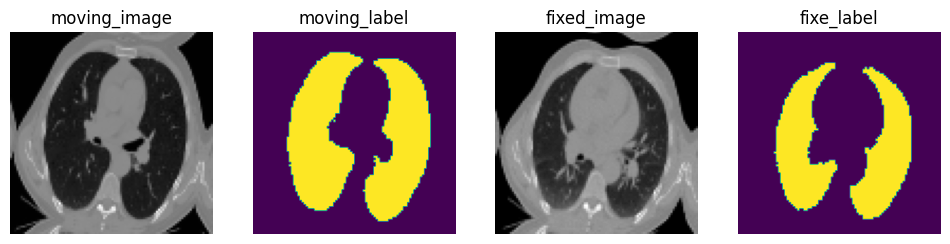

In [8]:
# plot the slice [:, :, 50]
plt.figure('check', (12, 6))
plt.subplot(1, 4, 1)
plt.title('moving_image')
plt.imshow(moving_image[:, :, 50], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('moving_label')
plt.imshow(moving_label[:, :, 50])
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('fixed_image')
plt.imshow(fixed_image[:, :, 50], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('fixe_label')
plt.imshow(fixed_label[:, :, 50])
plt.axis('off')

plt.show()

### 1. 3 データセット, データローダ

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                       cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms,
                     cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


## 2. 学習
### 2.1 モデルの定義

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[3],
    out_activation=None,
    out_kernel_initializer='zeros',
).to(device)

warp_layer = Warp().to(device)
image_loss = MSELoss()
label_loss = DiceLoss()
label_loss = MultiScaleLoss(label_loss, scales=[0, 1, 2, 4, 8, 16])
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
dice_metric = DiceMetric(include_background=True, reduction='mean', get_not_nans=False)

In [12]:
def forward(batch_data, model):
    fixed_image = batch_data['fixed_image'].to(device)
    moving_image = batch_data['moving_image'].to(device)
    moving_label = batch_data['moving_label'].to(device)
    
    # predict DDF through LocalNet
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))
    
    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)
    pred_label = warp_layer(moving_label, ddf)
    
    return ddf, pred_image, pred_label

### 2.2 モデルの学習

In [13]:
max_epochs = 5
val_interval = 1

model_dir = os.path.realpath('./models')
os.makedirs(model_dir, exist_ok=True)

In [14]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# epochループ
for epoch in range(max_epochs):
    # 評価
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_ddf, val_pred_image, val_pred_label = forward(val_data, model)
                val_pred_label[val_pred_label > 1] = 1
                
                val_fixed_image = val_data['fixed_image'].to(device)
                val_fixed_label = val_data['fixed_label'].to(device)
                dice_metric(y_pred=val_pred_label, y=val_fixed_label)
                
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_dir, 'best_metric_model.path'))
                print('saved new best metric model')
            print(
                f'current epoch: {epoch + 1} '
                f'current mena dice: {metric:.4f}\n'
                f'best mean dice: {best_metric:.4f} '
                f'at epoch: {best_metric_epoch}'
            )
    # 学習
    print('-' * 10)
    print(f'epoch {epoch + 1}/{max_epochs}')
    model.train()
    epoch_loss = 0
    step = 0
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()
        
        ddf, pred_image, pred_label = forward(batch_data, model)
        pred_label[pred_label > 1] = 1
        
        fixed_image = batch_data['fixed_image'].to(device)
        fixed_label = batch_data['fixed_label'].to(device)
        loss = image_loss(pred_image, fixed_image) + 100 * \
            label_loss(pred_label, fixed_label) + 10 * regularization(ddf)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch + 1} average loss: {epoch_loss:.4f}')

saved new best metric model
current epoch: 1 current mena dice: 0.7976
best mean dice: 0.7976 at epoch: 1
----------
epoch 1/5
epoch 1 average loss: 38.6302
current epoch: 2 current mena dice: 0.7972
best mean dice: 0.7976 at epoch: 1
----------
epoch 2/5
epoch 2 average loss: 38.2695
saved new best metric model
current epoch: 3 current mena dice: 0.7976
best mean dice: 0.7976 at epoch: 3
----------
epoch 3/5
epoch 3 average loss: 38.3983
saved new best metric model
current epoch: 4 current mena dice: 0.8027
best mean dice: 0.8027 at epoch: 4
----------
epoch 4/5
epoch 4 average loss: 38.5173
saved new best metric model
current epoch: 5 current mena dice: 0.8099
best mean dice: 0.8099 at epoch: 5
----------
epoch 5/5
epoch 5 average loss: 37.9638


In [15]:
print(f'train completed, '
      f'best_metric: {best_metric:.4f} '
      f'at epoch: {best_metric_epoch}')

train completed, best_metric: 0.8099 at epoch: 5


### 2.3 Loss, Metricのプロット

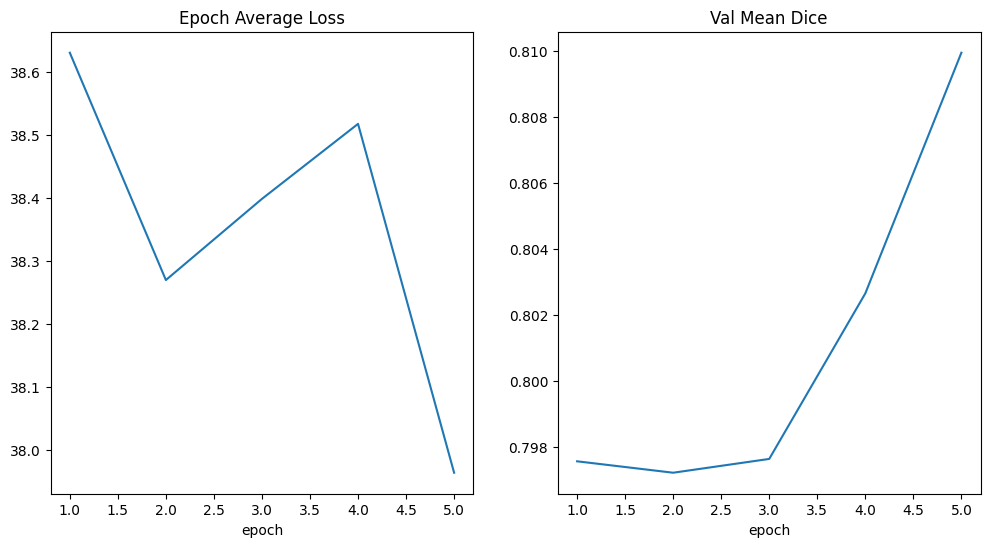

In [16]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title('Val Mean Dice')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## 3. 評価

In [17]:
# 学習済みモデルのダウンロード
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/pair_lung_ct.pth"

dst = f'{model_dir}/pretrained_weight.pth'
download_url(resource, dst)
model.load_state_dict(torch.load(dst))

2023-01-24 11:58:04,476 - INFO - Expected md5 is None, skip md5 check for file /home/akira/Medical/MONAI/3d_registration/models/pretrained_weight.pth.
2023-01-24 11:58:04,477 - INFO - File exists: /home/akira/Medical/MONAI/3d_registration/models/pretrained_weight.pth, skipped downloading.


<All keys matched successfully>

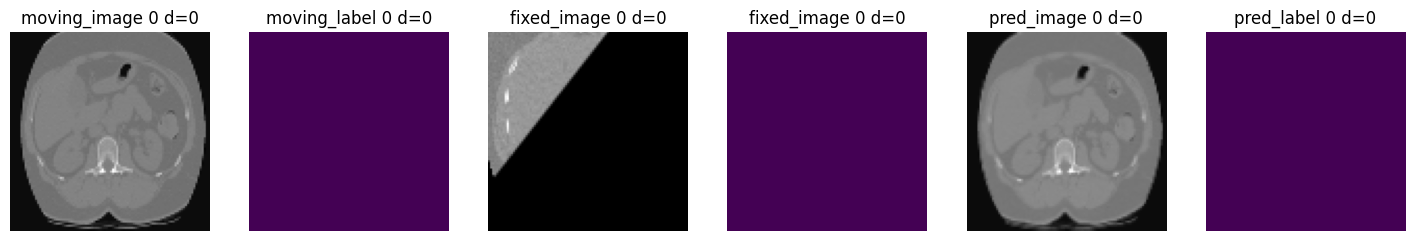

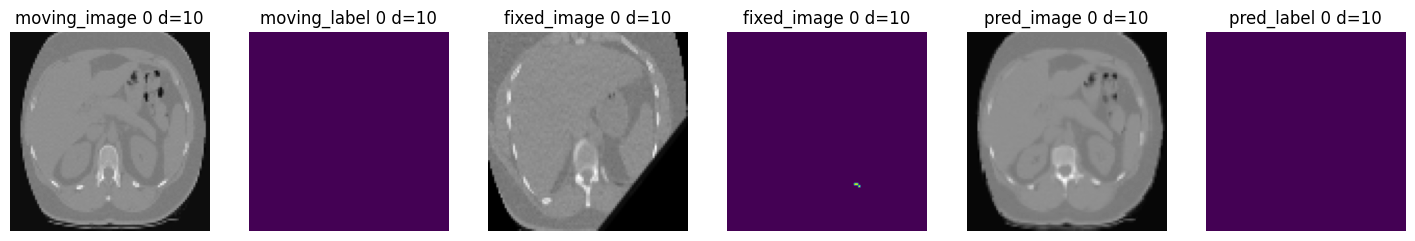

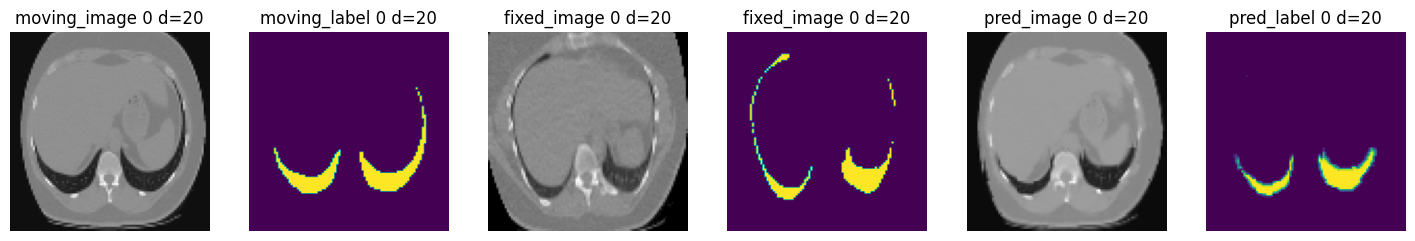

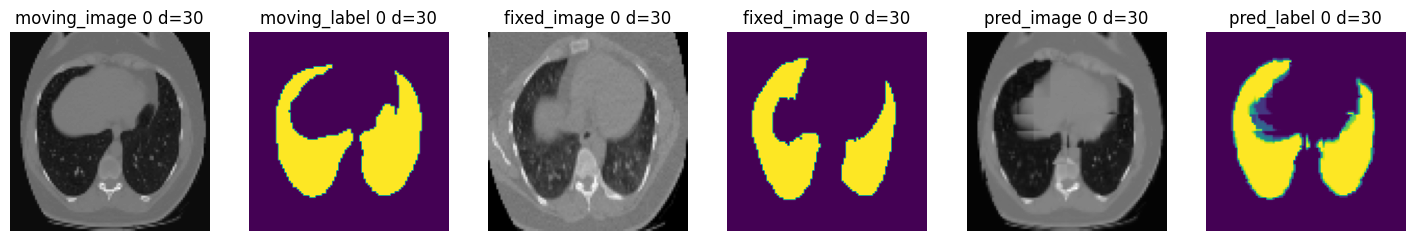

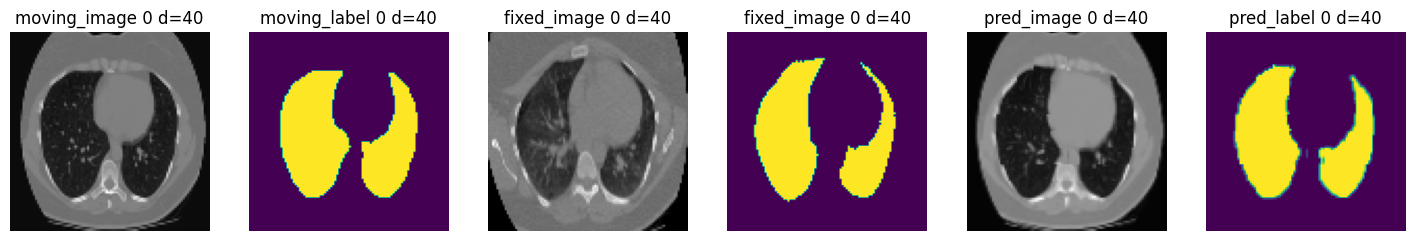

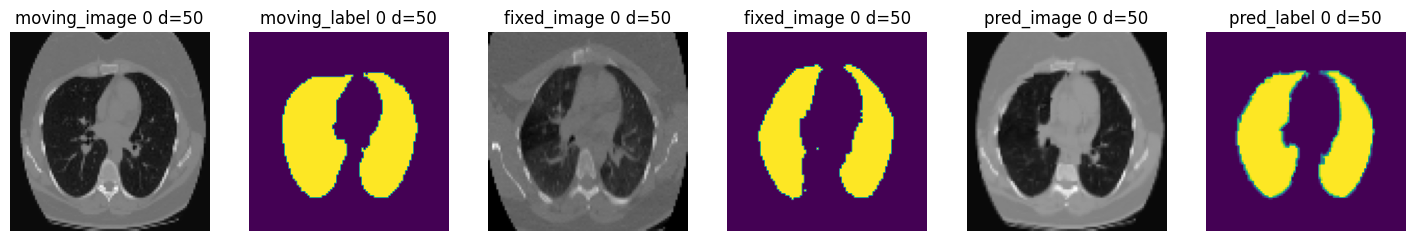

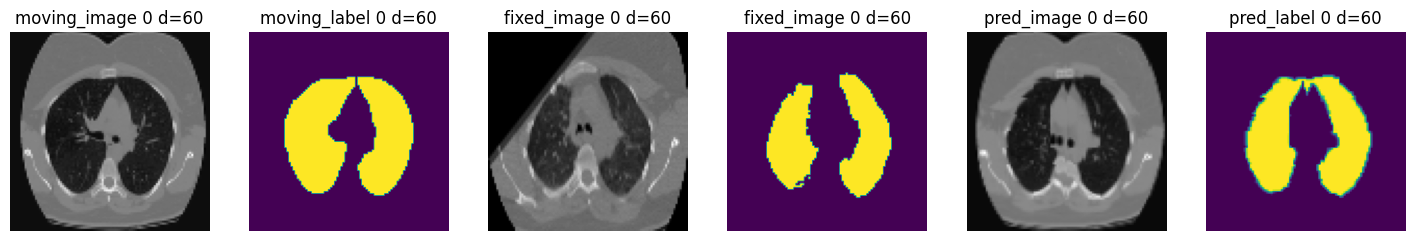

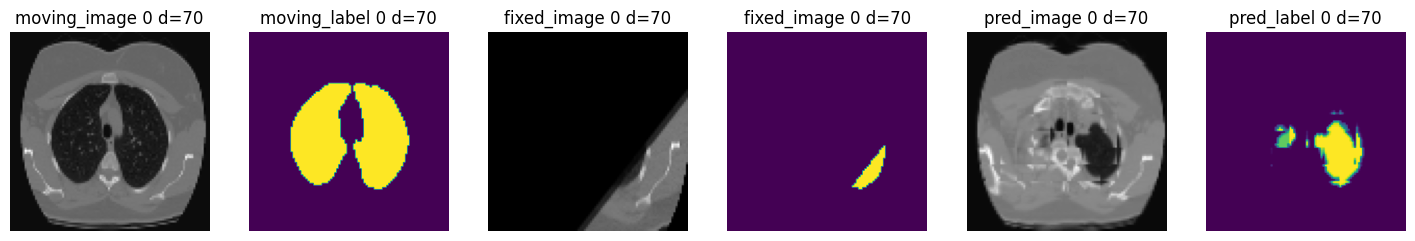

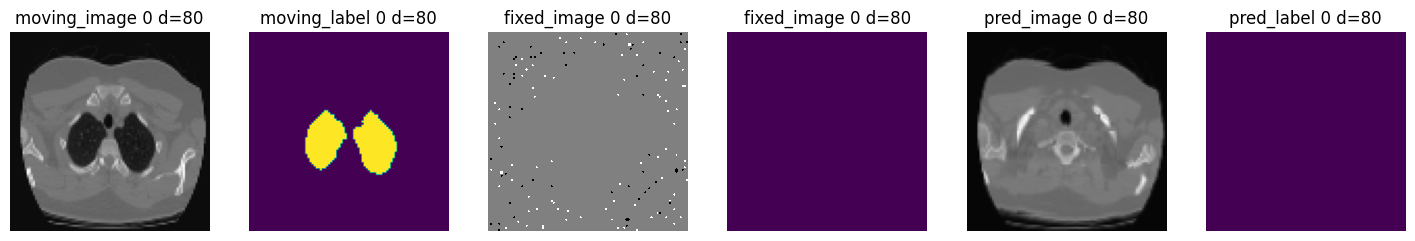

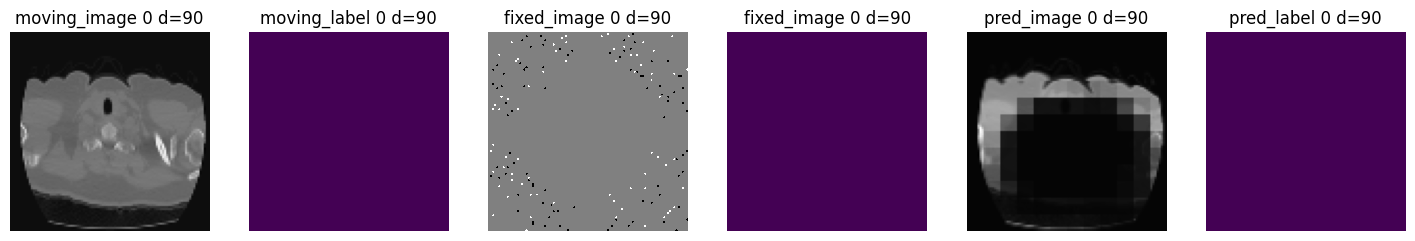

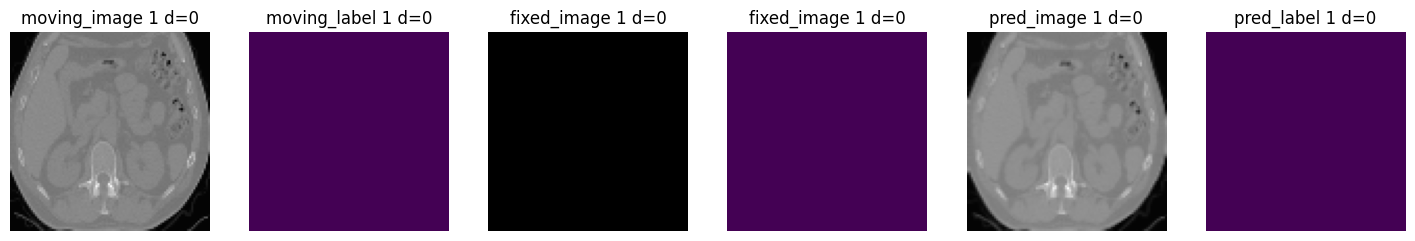

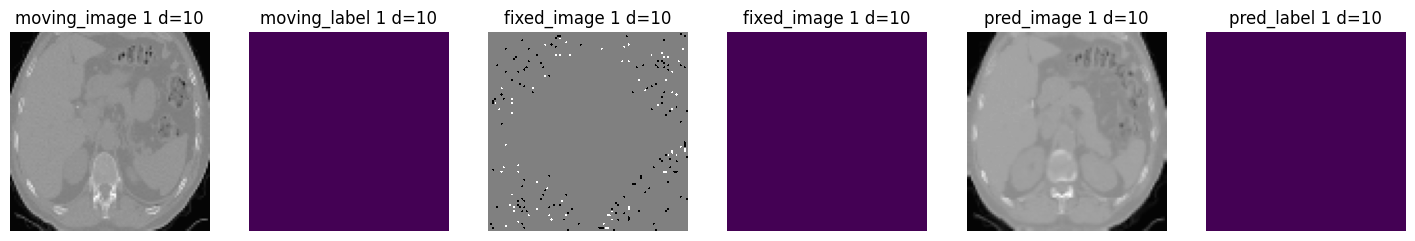

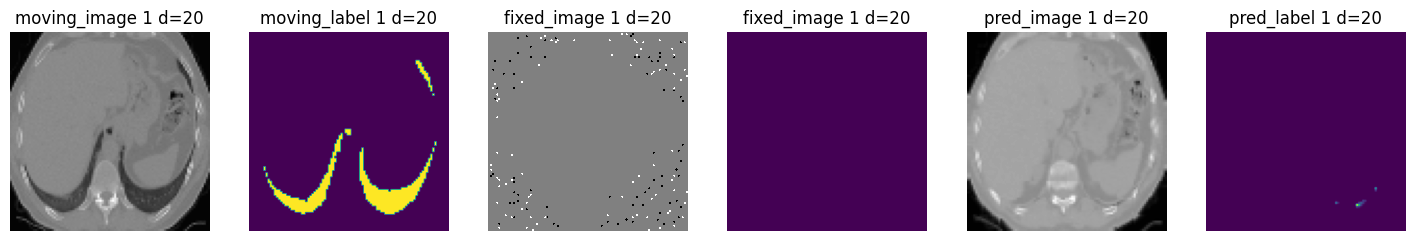

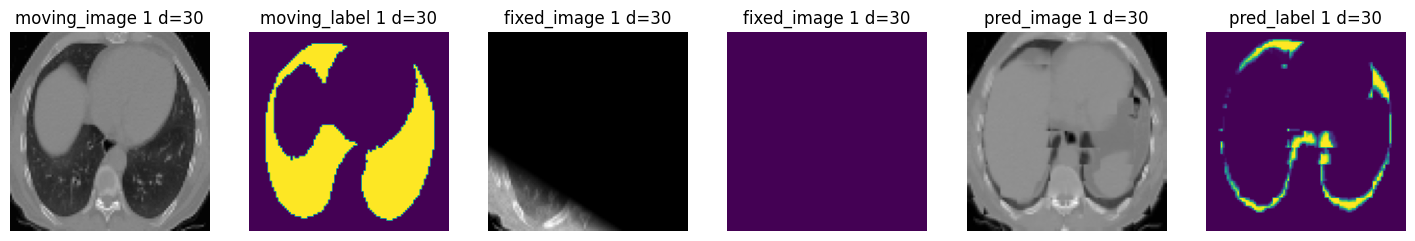

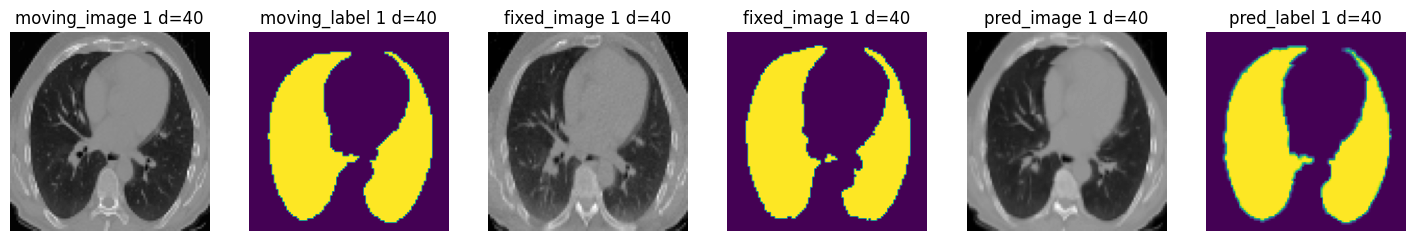

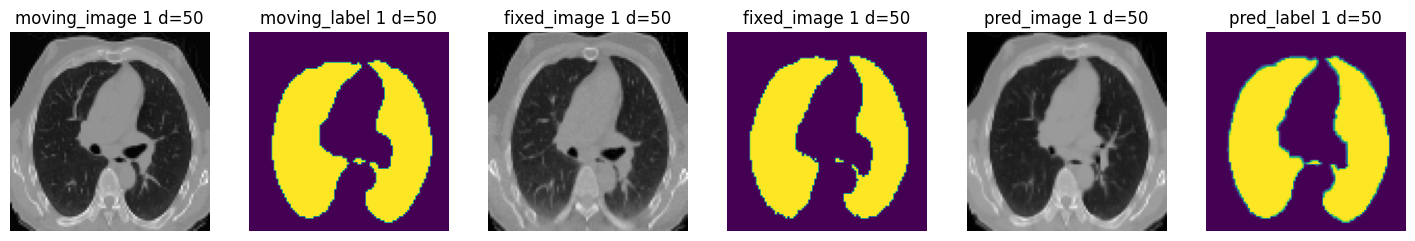

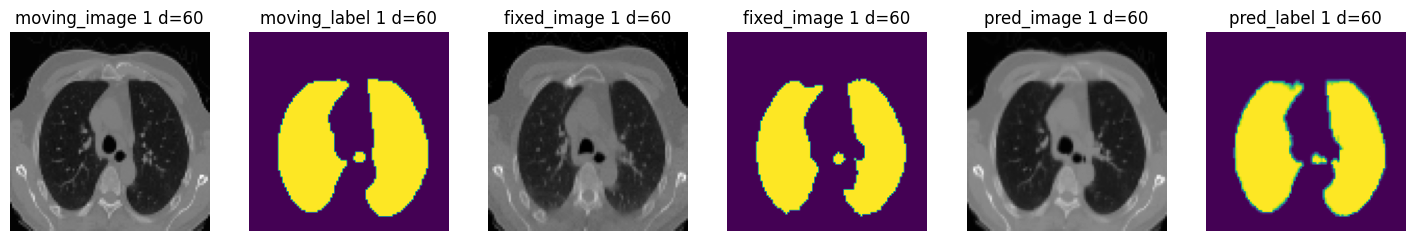

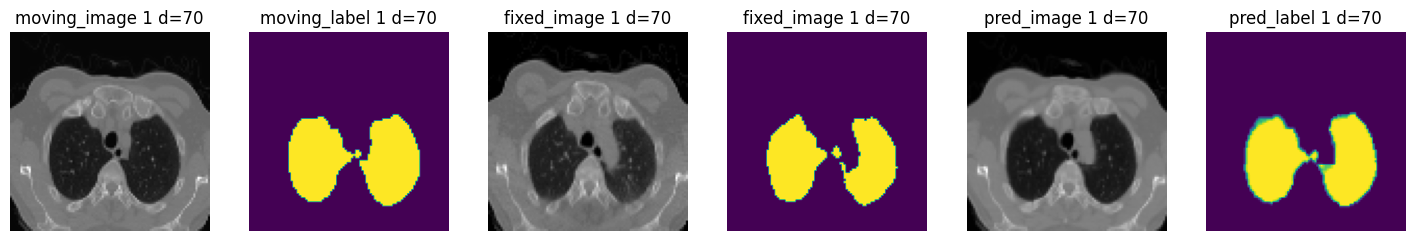

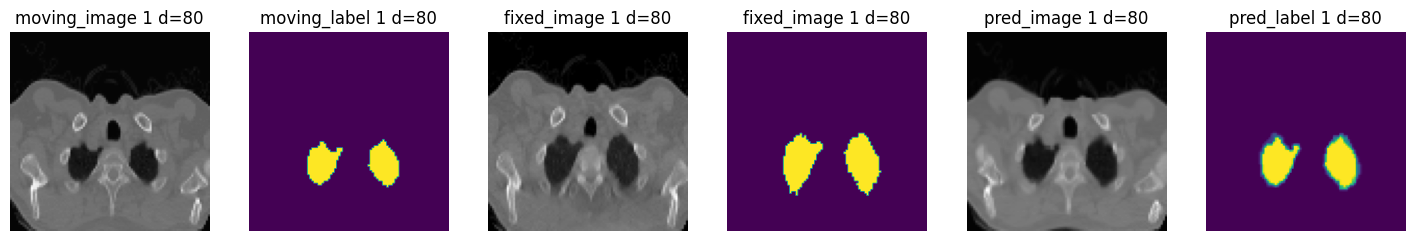

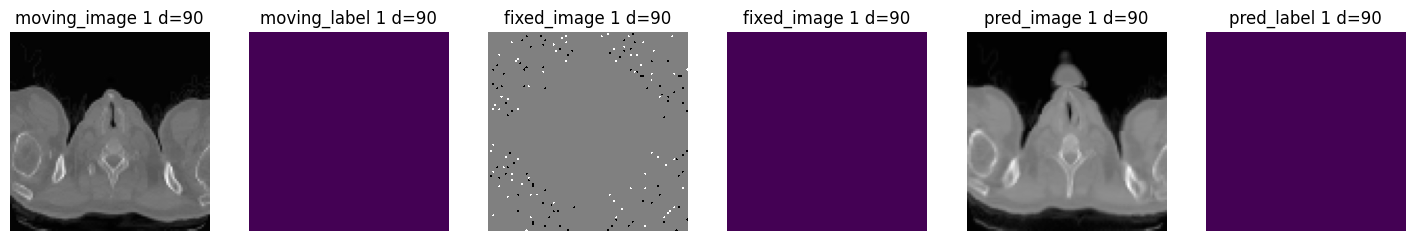

In [18]:
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i > 2:
            break
        val_dff, val_pred_image, val_pred_label = forward(val_data, model)
        val_pred_image = val_pred_image.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_pred_label = val_pred_label.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_image = val_data['moving_image'].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_label = val_data['moving_label'].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_image = val_data['fixed_image'].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_label = val_data['fixed_label'].cpu().numpy()[0, 0].transpose((1, 0, 2))
        
        for depth in range(10):
            depth = depth * 10
            # plot the slice [:, :, 80]
            plt.figure('check', (18, 6))
            plt.subplot(1, 6, 1)
            plt.title(f'moving_image {i} d={depth}')
            plt.imshow(val_moving_image[:, :, depth], cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 6, 2)
            plt.title(f'moving_label {i} d={depth}')
            plt.imshow(val_moving_label[:, :, depth])
            plt.axis('off')
            
            plt.subplot(1, 6, 3)
            plt.title(f'fixed_image {i} d={depth}')
            plt.imshow(val_fixed_image[:, :, depth], cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 6, 4)
            plt.title(f'fixed_image {i} d={depth}')
            plt.imshow(val_fixed_label[:, :, depth])
            plt.axis('off')
            
            plt.subplot(1, 6, 5)
            plt.title(f'pred_image {i} d={depth}')
            plt.imshow(val_pred_image[:, :, depth], cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 6, 6)
            plt.title(f'pred_label {i} d={depth}')
            plt.imshow(val_pred_label[:, :, depth])
            plt.axis('off')
            plt.show()
            